# GalaxyMorph (Layer 1) — Baseline Galaxy Morphology Classifier 🌌🧠

**Goal (Layer 1):** build a clean, reproducible baseline that predicts galaxy morphology from images and produces *real* evaluation artifacts (macro-F1, confusion matrix, failure cases).

**Dataset:** Galaxy Zoo 2 images (Kaggle input)

**Deliverables for Layer 1:**
- Train/val/test split
- Transfer-learning CNN baseline (ResNet-18)
- Metrics: macro-F1 + per-class precision/recall
- Confusion matrix + “confident mistakes” gallery

We’ll build this in steps so every step produces something you can *see* and trust.

# 1. Exploring the Dataset

In [1]:
import zipfile
from pathlib import Path

COMP_DIR = Path("/kaggle/input/competitions/galaxy-zoo-the-galaxy-challenge")

# Adjust this if your folder name is slightly different
print(COMP_DIR)

# Unzip training images
with zipfile.ZipFile(COMP_DIR / "images_training_rev1.zip", 'r') as z:
    z.extractall("/kaggle/working")

# Unzip training labels
with zipfile.ZipFile(COMP_DIR / "training_solutions_rev1.zip", 'r') as z:
    z.extractall("/kaggle/working")

print("Extraction done.")

/kaggle/input/competitions/galaxy-zoo-the-galaxy-challenge
Extraction done.


In [2]:
from pathlib import Path

WORK_DIR = Path("/kaggle/working")

IMG_DIR = WORK_DIR / "images_training_rev1"
LABELS_CSV = WORK_DIR / "training_solutions_rev1.csv"

print("Images exist:", IMG_DIR.exists())
print("Labels exist:", LABELS_CSV.exists())

Images exist: True
Labels exist: True


In [3]:
import pandas as pd

df = pd.read_csv(LABELS_CSV)
print(df.shape)
df.head()

(61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


# 2. Building 3-class Labels (Elliptical / Spiral / Irregular) from Vote Fractions

In [4]:
import numpy as np

# 3-class probability mapping (Layer 1)
df["p_elliptical"] = df["Class1.1"]                 # smooth
df["p_spiral"]     = df["Class1.2"] * df["Class2.1"]# features/disk AND spiral
df["p_irregular"]  = df["Class1.2"] * df["Class6.1"]# features/disk AND odd

probs = df[["p_elliptical","p_spiral","p_irregular"]].values
df["p_max"] = probs.max(axis=1)
df["label"] = probs.argmax(axis=1)

label_names = {0:"elliptical", 1:"spiral", 2:"irregular"}
df["label_name"] = df["label"].map(label_names)

df[["GalaxyID","p_elliptical","p_spiral","p_irregular","p_max","label_name"]].head()

,GalaxyID,p_elliptical,p_spiral,p_irregular,p_max,label_name
0,100008,0.383147,0.000000,0.033589,0.383147,elliptical
1,100023,0.327001,0.020695,0.125553,0.327001,elliptical
2,100053,0.765717,0.000000,0.000000,0.765717,elliptical
3,100078,0.693377,0.000000,0.076435,0.693377,elliptical
4,100090,0.933839,0.000000,0.000000,0.933839,elliptical


In [5]:
df["label_name"].value_counts()

label_name
elliptical    41401
irregular     14196
spiral         5981
Name: count, dtype: int64

# 3. Filtering to “High Confidence” Galaxies (Clean Baseline)

This step removes ambiguous examples for Layer 1 so training is stable and evaluation is interpretable.

In [5]:
CONF_THRESH = 0.70
df_clean = df[df["p_max"] >= CONF_THRESH].copy()

print("Original:", len(df))
print("After confidence filter:", len(df_clean))
print(df_clean["label_name"].value_counts())

Original: 61578
After confidence filter: 16853
label_name
elliptical    14146
spiral         1570
irregular      1137
Name: count, dtype: int64


# 4. Attaching Image Filepaths and Verifying They Exist

In [6]:
from pathlib import Path

IMG_DIR = Path("/kaggle/working/images_training_rev1")

df_clean["filepath"] = df_clean["GalaxyID"].apply(lambda x: str(IMG_DIR / f"{int(x)}.jpg"))

# Check missing files (should be 0)
missing = (~df_clean["filepath"].apply(lambda p: Path(p).exists())).sum()
print("Missing image files:", missing)

df_clean[["GalaxyID","filepath","label_name"]].head()

Missing image files: 0


,GalaxyID,filepath,label_name
2,100053,/kaggle/working/images_training_rev1/100053.jpg,elliptical
4,100090,/kaggle/working/images_training_rev1/100090.jpg,elliptical
5,100122,/kaggle/working/images_training_rev1/100122.jpg,elliptical
16,100263,/kaggle/working/images_training_rev1/100263.jpg,irregular
18,100295,/kaggle/working/images_training_rev1/100295.jpg,elliptical


# 5. Quick Visual Sanity: show a few from each class

This step does sanity-check label mapping visually (super important).

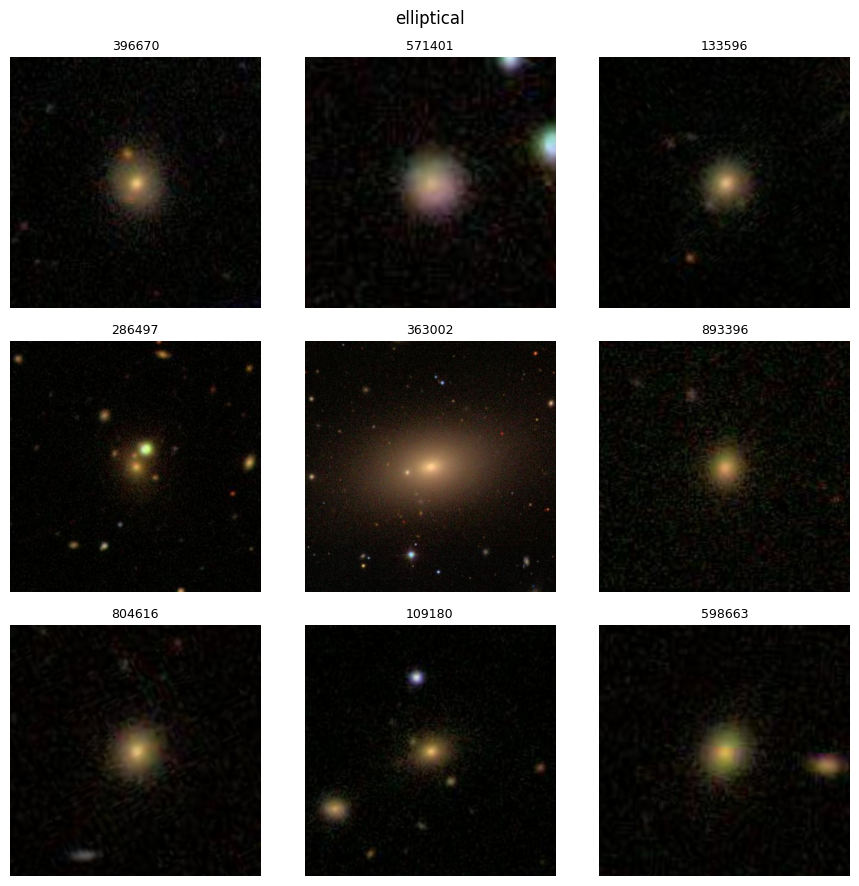

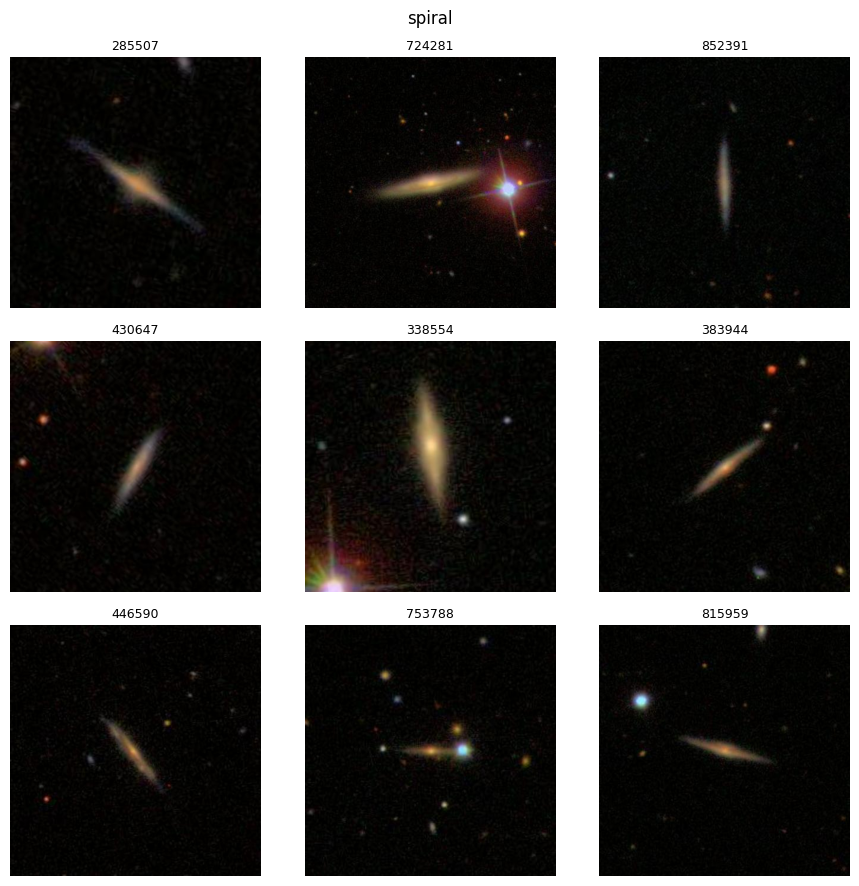

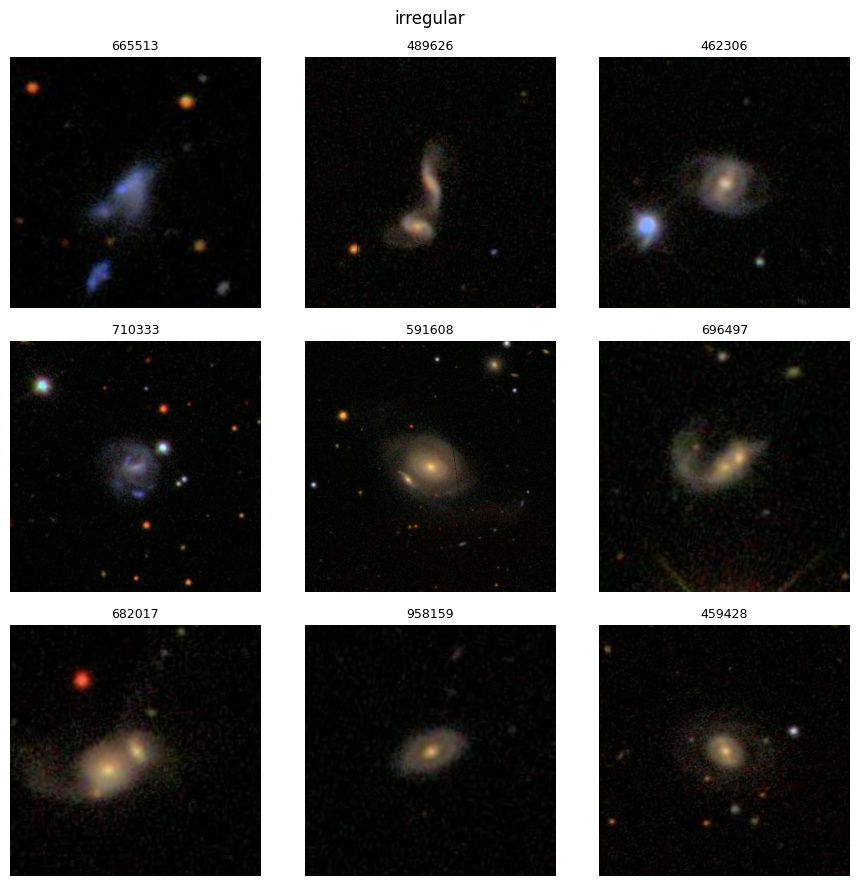

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random, math

def show_class_examples(df_in, class_name, n=9):
    subset = df_in[df_in["label_name"] == class_name]
    rows = subset.sample(n=min(n, len(subset)), random_state=0)
    cols = 3
    r = math.ceil(len(rows)/cols)
    plt.figure(figsize=(cols*3, r*3))
    for i, (_, row) in enumerate(rows.iterrows(), 1):
        img = Image.open(row["filepath"]).convert("RGB")
        plt.subplot(r, cols, i)
        plt.imshow(img)
        plt.title(f'{row["GalaxyID"]}', fontsize=9)
        plt.axis("off")
    plt.suptitle(class_name)
    plt.tight_layout()
    plt.show()

for cname in ["elliptical","spiral","irregular"]:
    show_class_examples(df_clean, cname, n=9)

# 6. Splitting Train/Val/Test

In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_clean, test_size=0.30, random_state=42, stratify=df_clean["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df["label"]
)

print(len(train_df), len(val_df), len(test_df))
print("Train:\n", train_df["label_name"].value_counts(), "\n")
print("Val:\n", val_df["label_name"].value_counts(), "\n")
print("Test:\n", test_df["label_name"].value_counts())

11797 2528 2528
Train:
 label_name
elliptical    9902
spiral        1099
irregular      796
Name: count, dtype: int64 

Val:
 label_name
elliptical    2122
spiral         235
irregular      171
Name: count, dtype: int64 

Test:
 label_name
elliptical    2122
spiral         236
irregular      170
Name: count, dtype: int64


# 7. Building Dataset/DataLoader

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class GalaxyDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        img = self.transform(img)
        label = int(row["label"])
        return img, label

BATCH_SIZE = 64
train_loader = DataLoader(GalaxyDataset(train_df, train_tfms), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(GalaxyDataset(val_df,   eval_tfms), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(GalaxyDataset(test_df,  eval_tfms), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# 8. Training a ResNet-18 Transfer Learning Baseline

In [10]:
import torch.nn as nn
from torchvision import models
from sklearn.metrics import f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

# Freeze backbone: train only the head first
for name, p in model.named_parameters():
    if not name.startswith("fc."):
        p.requires_grad = False

# Class weights (helps imbalance)
counts = train_df["label"].value_counts().sort_index().values
weights = (1.0 / counts)
weights = weights / weights.sum() * len(counts)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    all_preds, all_labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return total_loss/len(loader.dataset), f1_score(all_labels, all_preds, average="macro")

best_path = "best_resnet18_layer1.pt"
best_val = -1

EPOCHS = 3
for ep in range(1, EPOCHS+1):
    tr_loss, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_f1 = run_epoch(val_loader, train=False)
    print(f"Epoch {ep}/{EPOCHS} | train loss {tr_loss:.4f} f1 {tr_f1:.3f} | val loss {va_loss:.4f} f1 {va_f1:.3f}")
    if va_f1 > best_val:
        best_val = va_f1
        torch.save(model.state_dict(), best_path)

print("Best val macro-F1:", best_val)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s] 


Epoch 1/3 | train loss 0.8757 f1 0.482 | val loss 0.8030 f1 0.443
Epoch 2/3 | train loss 0.6438 f1 0.632 | val loss 0.6820 f1 0.577
Epoch 3/3 | train loss 0.5755 f1 0.655 | val loss 0.6350 f1 0.557
Best val macro-F1: 0.5767795667830569


## 8.1. Unfreezing the Last ResNet Block and Fine-Tune

In [13]:
# Load best head-only model
model.load_state_dict(torch.load(best_path, map_location=device))

# Unfreeze layer4 + fc
for name, p in model.named_parameters():
    if name.startswith("layer4.") or name.startswith("fc."):
        p.requires_grad = True
    else:
        p.requires_grad = False

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

best_val_ft = -1
best_path_ft = "best_resnet18_finetuned.pt"

EPOCHS_FT = 3

for ep in range(1, EPOCHS_FT+1):
    tr_loss, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_f1 = run_epoch(val_loader, train=False)

    print(f"[FT] Epoch {ep}/{EPOCHS_FT} | train loss {tr_loss:.4f} f1 {tr_f1:.3f} | val loss {va_loss:.4f} f1 {va_f1:.3f}")

    if va_f1 > best_val_ft:
        best_val_ft = va_f1
        torch.save(model.state_dict(), best_path_ft)

print("Best val macro-F1 (fine-tuned):", best_val_ft)

[FT] Epoch 1/3 | train loss 0.2926 f1 0.784 | val loss 0.1937 f1 0.849
[FT] Epoch 2/3 | train loss 0.1897 f1 0.858 | val loss 0.1690 f1 0.904
[FT] Epoch 3/3 | train loss 0.1649 f1 0.865 | val loss 0.1374 f1 0.873
Best val macro-F1 (fine-tuned): 0.9041626431425577


## 8.2. Model Performance on Validation Data

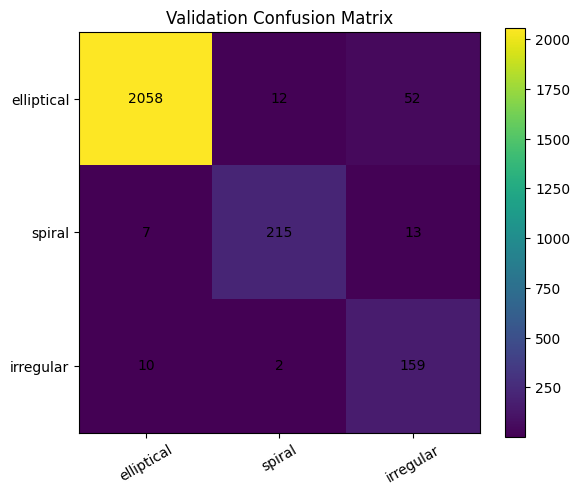

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.load_state_dict(torch.load(best_path_ft, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.xticks([0,1,2], ["elliptical","spiral","irregular"], rotation=30)
plt.yticks([0,1,2], ["elliptical","spiral","irregular"])
plt.title("Validation Confusion Matrix")
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()

# 9. Evaluating on the Test Set

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load best fine-tuned model
model.load_state_dict(torch.load(best_path_ft, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("Test macro-F1:", f1_score(all_labels, all_preds, average="macro"))
print(classification_report(all_labels, all_preds, target_names=["elliptical","spiral","irregular"]))

Test macro-F1: 0.9015796889831852
              precision    recall  f1-score   support

  elliptical       0.99      0.97      0.98      2122
      spiral       0.93      0.93      0.93       236
   irregular       0.72      0.89      0.80       170

    accuracy                           0.96      2528
   macro avg       0.88      0.93      0.90      2528
weighted avg       0.97      0.96      0.96      2528



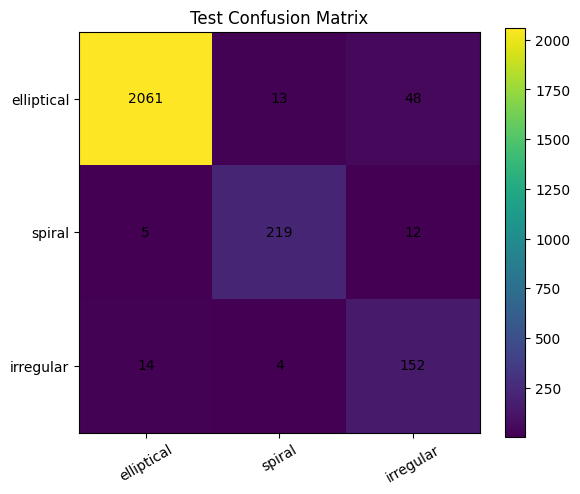

In [16]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.xticks([0,1,2], ["elliptical","spiral","irregular"], rotation=30)
plt.yticks([0,1,2], ["elliptical","spiral","irregular"])
plt.title("Test Confusion Matrix")
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.tight_layout()
plt.show()

# 10. The "Confident Mistake" Gallery

In [18]:
import torch.nn as nn
from PIL import Image
import math
import random

softmax = nn.Softmax(dim=1)

# We'll need filepaths aligned with test_df
test_df_reset = test_df.reset_index(drop=True).copy()

all_probs = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        probs = softmax(model(x)).cpu().numpy()
        all_probs.append(probs)
all_probs = np.concatenate(all_probs)

# Add preds + confidence
test_df_reset["pred"] = all_preds
test_df_reset["conf"] = all_probs.max(axis=1)

# Top confident wrong predictions
wrong = test_df_reset[test_df_reset["pred"] != test_df_reset["label"]].sort_values("conf", ascending=False).head(12)
wrong[["GalaxyID","label_name","pred","conf"]]

,GalaxyID,label_name,pred,conf
1444,369314,spiral,2,0.999804
985,125686,elliptical,2,0.997915
1561,658291,irregular,1,0.996549
449,678055,irregular,0,0.987716
511,758560,elliptical,1,0.987689
223,864781,elliptical,2,0.984890
2263,709669,elliptical,2,0.983275
1007,149983,elliptical,1,0.978223
1066,458916,irregular,0,0.968899
1975,144007,elliptical,2,0.956588


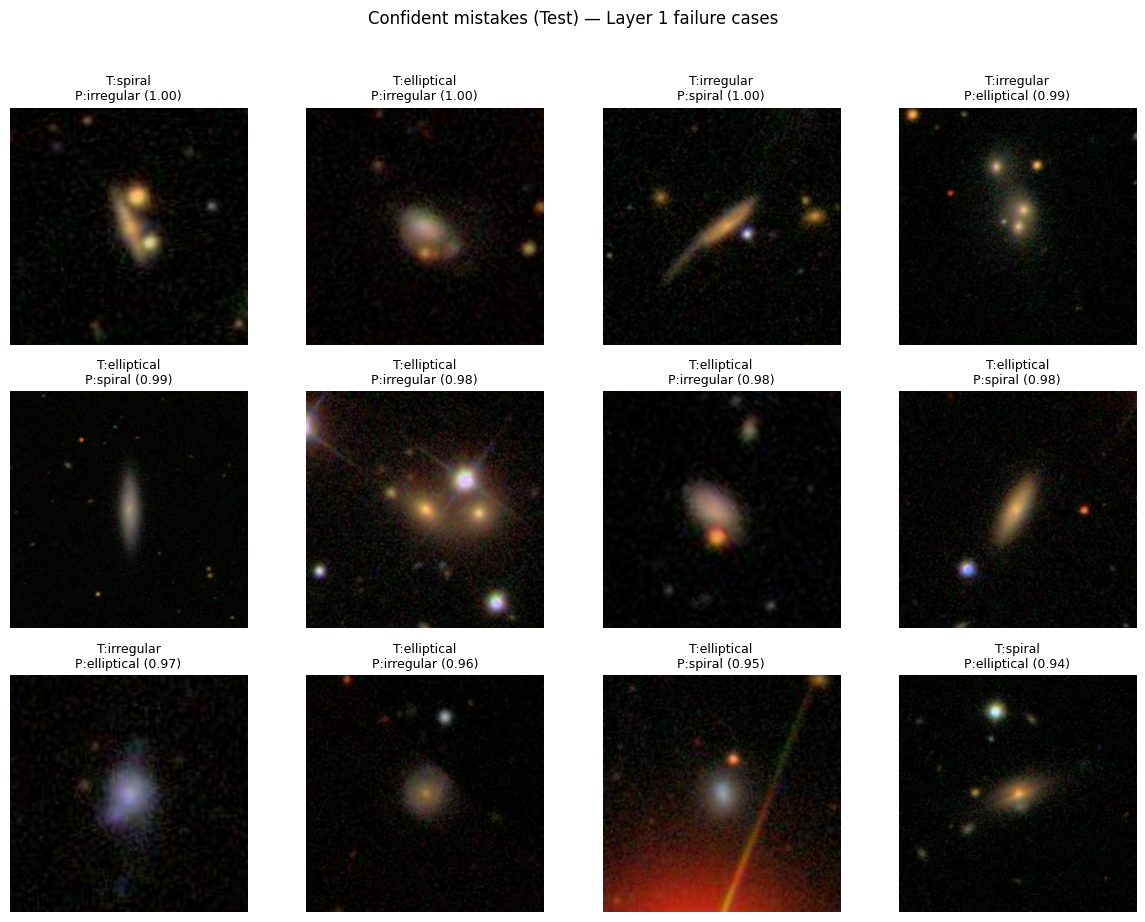

In [19]:
label_names = {0:"elliptical", 1:"spiral", 2:"irregular"}

plt.figure(figsize=(12, 9))
for i, (_, r) in enumerate(wrong.iterrows(), 1):
    img = Image.open(r["filepath"]).convert("RGB")
    plt.subplot(3, 4, i)
    plt.imshow(img)
    t = r["label_name"]
    p = label_names[int(r["pred"])]
    plt.title(f"T:{t}\nP:{p} ({r['conf']:.2f})", fontsize=9)
    plt.axis("off")
plt.suptitle("Confident mistakes (Test) — Layer 1 failure cases", y=1.02)
plt.tight_layout()
plt.show()

# 11. Saving the Splits + Config

In [20]:
from pathlib import Path

OUT = Path("/kaggle/working/galaxymorph_layer1")
OUT.mkdir(parents=True, exist_ok=True)

train_df.to_csv(OUT/"train_split.csv", index=False)
val_df.to_csv(OUT/"val_split.csv", index=False)
test_df.to_csv(OUT/"test_split.csv", index=False)

print("Saved splits to:", OUT)

Saved splits to: /kaggle/working/galaxymorph_layer1


In [21]:
import json

config = {
    "conf_thresh": float(CONF_THRESH),
    "img_size": int(IMG_SIZE),
    "model": "resnet18",
    "training": {
        "head_epochs": int(EPOCHS),
        "ft_epochs": int(EPOCHS_FT),
        "lr_head": 3e-4,
        "lr_ft": 1e-4,
        "batch_size": int(BATCH_SIZE),
        "fine_tune": "layer4+fc"
    }
}

with open(OUT/"config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Saved config.json")

Saved config.json
